# Homework 4
## Data Analysis
### FINM August Review 

Mark Hendricks

hendricks@uchicago.edu

TA: Maneet Singh

# 1 Models of Volatility

We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-$t$ return volatility, as based on data over periods through $t-1$, but not including $t$ itself. 

This problem uses data from `../data/multi_asset_etf_data.xlsx`.

Estimate the following using the SPY return series. We use a common (but biased) version of the usual variance estimator by ignoring $\mu$ and dividing by the number of data points, rather than by the degrees of freedom. 

### Expanding Series
$$\begin{align*}
\sigma^2_{t} =& \frac{1}{t-1}\sum_{\tau=1}^{t-1} r_\tau ^ 2
\end{align*}$$

Begin the calculation at $t=61$, so that the first estimate is based on 60 data points.

### Rolling Window
\begin{align*}
\sigma^2_{t} =& \frac{1}{m}\sum_{l=1}^{m} r_{t-l}^2
\end{align*}
Use $m=60$, and begin the calculation at the $t=61$, (so that the calculation has a full 60 data points.) Consider, (if you have a pandas dataframe named, \texttt{df},) using pandas method \texttt{df.rolling(60).std()}

### IGARCH 
(famously used in \textit{Risk Metrics})
$$\begin{align*}
\sigma^2_{t} =& \theta \sigma^2_{t-1} + (1-\theta) r_{t-1}^2
\end{align*}$$

Rather than estimating $\theta$, simply use $\theta = 0.97$, and initialize with $\sigma_1 = 0.15\left(\frac{1}{\sqrt{12}}\right)$.


### GARCH(1,1)
$$\begin{align*}
\sigma^2_{t} =& \omega + \theta \sigma^2_{t-1} + \gamma r_{t-1}^2
\end{align*}$$

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine, (and will account for $\mu$ and degrees of freedom.) 

# Exercise
For each of these methods, 
* plot $\sigma_t$. (Plot the volatility, the square-root of the variance.)
* report the estimation for October 2008, April 2020, and May 2022.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 

## Setup

In [3]:
spy = pd.read_excel('../data/hw_3_2_data.xlsx',sheet_name='s&p500').set_index('Date')
FREQ = 12

## Initial Conditions

In [4]:
var_1 = (0.15 * (1 / (12**0.5)))**2
theta = 0.97

## Calculate the Expanding Series and Rolling Window estimates:

In [5]:
### Expanding Window
var = (spy**2).shift(1).expanding().mean().rename(columns={'SPY':'Expanding Window'})

### Rolling Window
var['Rolling Window'] = (spy**2).shift(1).rolling(5*FREQ).mean() 

## Using the arch package, fit a GARCH(1, 1) model. We will use the parameters generated to find our estimates:

In [6]:
GARCH = arch_model(spy, vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 159853465.98835444
Iteration:      2,   Func. Count:     17,   Neg. LLF: 38574.889726670124
Iteration:      3,   Func. Count:     24,   Neg. LLF: -604.8147269019737
Iteration:      4,   Func. Count:     31,   Neg. LLF: -530.8967779781474
Iteration:      5,   Func. Count:     37,   Neg. LLF: -639.4946352246784
Iteration:      6,   Func. Count:     43,   Neg. LLF: -641.555322563592
Iteration:      7,   Func. Count:     49,   Neg. LLF: -628.3163493968602
Iteration:      8,   Func. Count:     55,   Neg. LLF: -641.5148844152397
Iteration:      9,   Func. Count:     61,   Neg. LLF: -642.3497654103053
Iteration:     10,   Func. Count:     66,   Neg. LLF: -642.3514072120245
Iteration:     11,   Func. Count:     71,   Neg. LLF: -642.3514188624413
Iteration:     12,   Func. Count:     76,   Neg. LLF: -642.3514188206216
Optimization terminated successfully    (Exit mode 0)
            Current function value: -642.3514191026803
            Iter

mu          0.009802
omega       0.000089
alpha[1]    0.196704
beta[1]     0.772624
Name: params, dtype: float64

We have $\theta$ so we do not need the step below to find our estimates. However, this is an example of how to use the arch package to fit an IGARCH model. The package has several methods that could be useful in other applications.

In [7]:
IGARCH = arch_model(spy)

IGARCH.volatility = EWMAVariance(theta)

IGARCH_model = IGARCH.fit()

IGARCH_model.params

Iteration:      1,   Func. Count:      3,   Neg. LLF: 341784.50276505516
Iteration:      2,   Func. Count:     10,   Neg. LLF: -616.8017041280378
Optimization terminated successfully    (Exit mode 0)
            Current function value: -616.8017041280644
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


mu    0.008451
Name: params, dtype: float64

We calculate our variance estimates for the GARCH and IGARCH models:

In [8]:
var[['GARCH','IGARCH']] = None

### Initialize with the given parameter
var.iloc[0,2:] = var_1 

### Simulate the rest of the period using the initial variance given
for i in range(1, len(var)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    var['IGARCH'].iloc[i] = var['IGARCH'].iloc[i-1] * theta + (1-theta)*(spy.iloc[i-1,0]**2)
    var['GARCH'].iloc[i] = GARCH_model.params['omega'] + var['GARCH'].iloc[i-1] * GARCH_model.params['beta[1]'] + GARCH_model.params['alpha[1]']*(spy.iloc[i-1,0]**2)
    
var = var.dropna()

var.tail() * FREQ

,Expanding Window,Rolling Window,GARCH,IGARCH
Date,,,,
2022-02-28,0.022265,0.026288,0.026218,0.026989
2022-03-31,0.022231,0.026153,0.02338,0.026493
2022-04-30,0.022216,0.026435,0.022466,0.026207
2022-05-31,0.022416,0.027956,0.036608,0.028194
2022-06-30,0.022352,0.027917,0.029363,0.02735


Let's plot our volatility estimates now:

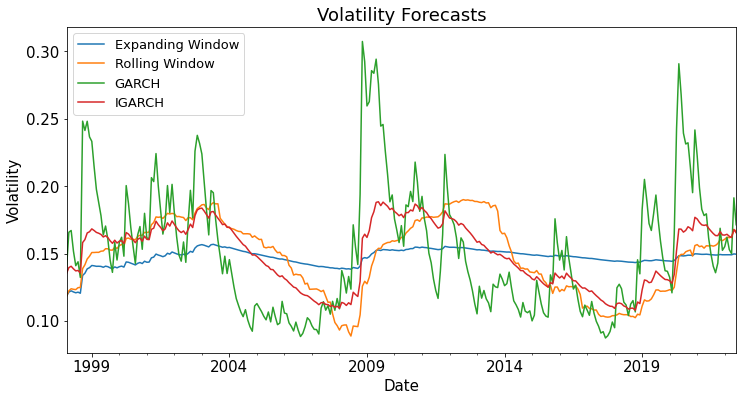

In [9]:
### Convert variance to volatility
vol = (var * FREQ)**.5

vol.plot()
plt.title('Volatility Forecasts')
plt.ylabel('Volatility')

plt.show()

In [10]:
dts = ['2008-10-31','2020-03-31','2022-05-31']
vol.loc[dts]

,Expanding Window,Rolling Window,GARCH,IGARCH
Date,,,,
2008-10-31,0.140610,0.104488,0.19377,0.12933
2020-03-31,0.144813,0.124986,0.164749,0.134557
2022-05-31,0.149719,0.167201,0.191332,0.16791
